In [467]:
import torch
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import lab as B

import neuralprocesses.torch as nps
from neuralprocesses.data.data import Aggregate, AggregateInput

from neuralprocesses.dist.uniform import UniformDiscrete
from matplotlib.patches import ConnectionPatch
from scipy.stats import gaussian_kde, norm

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

torch.no_grad().__enter__()

# Plot model predictions on real data

In [2]:
seed = 3
batch_size = 1
num_tasks = 2**10
device = "cpu"

generator = nps.SawtoothGenerator(
    torch.float32,
    seed=seed,
    batch_size=batch_size,
    num_tasks=num_tasks,
    device=device,
    num_context=UniformDiscrete(10, 11),
    num_target=UniformDiscrete(500, 501),
)

/Users/stratis/repos/qif/venv-qif/lib/python3.7/site-packages/lab/types.py:194: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if not isinstance(getattr(np, name), type):
/Users/stratis/repos/qif/venv-qif/lib/python3.7/site-packages/lab/types.py:199: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely eve

In [38]:
points_per_unit = 64
dim_x = 1
dim_yc = 1
dim_yt = 1
likelihood = "het"
conv_arch = "unet"
unet_channels = (64,) * 6
unet_strides = (2,) * 6
conv_channels = 64
conv_layers = 6
conv_receptive_field = None
dws_channels = conv_channels
dws_layers = conv_layers
dws_receptive_field = conv_receptive_field
margin = 0.1
encoder_scales = None
transform = None

# Create model
model = nps.construct_convgnp(
    points_per_unit=points_per_unit,
    dim_x=dim_x,
    dim_yc=dim_yc,
    dim_yt=dim_yt,
    likelihood=likelihood,
    conv_arch=conv_arch,
    unet_channels=unet_channels,
    dws_channels=dws_channels,
    dws_layers=dws_layers,
    dws_receptive_field=dws_receptive_field,
    margin=margin,
    encoder_scales=encoder_scales,
    transform=transform
)

# Load model weights
chkpt = "models/sawtooth-model-best.torch"
model.load_state_dict(torch.load(chkpt, map_location="cpu")["weights"])

# Make predictions
batch = generator.generate_batch()

Receptive field: 6.953


In [39]:
def save_and_increment(path, counter, show):
    
    path = f"{path}-{counter}.pdf"
    
    if show:
        plt.savefig(path)
        plt.show()
        
    else:
        plt.savefig(path)
        plt.close()
        
    return counter + 1

In [40]:
np.random.seed(0)
torch.random.manual_seed(0)
state = B.create_random_state(torch.float32, seed=0)
path = "img/sawtooth/sawtooth"
show = True
counter = 0
stop_frames = 5

x_plot = torch.linspace(-3., 3., 500)[None, None, :]

N = batch["contexts"][0][0].shape[-1]
i = 3

contexts = [
    (
        batch["contexts"][0][0][:, :, :i],
        batch["contexts"][0][1][:, :, :i]
    )
]

state, pred = model(state, contexts, x_plot)

_x_plot = x_plot.detach().numpy()[0, 0, :]
_mean = pred.mean.detach().numpy()[0, 0, :]
_std = pred.var.detach().numpy()[0, 0, :]**0.5

_xc = batch["contexts"][0][0][0, 0, :].detach().numpy()
_yc = batch["contexts"][0][1][0, 0, :].detach().numpy()

# plt.figure(figsize=(15, 4))
# plt.plot(_x_plot, _mean, color="tab:blue", alpha=1.0)
# plt.scatter(_xc[:i], _yc[:i], marker="+", color="black", s=150, zorder=3, linewidth=2.5)
# plt.scatter(_xc[i:N], _yc[i:N], marker="+", color="red", s=150, zorder=3, linewidth=2.5)
# plt.fill_between(_x_plot, _mean-2.*_std, _mean+2.*_std, color="tab:blue", alpha=0.5)
# plt.xlim([-3., 3.])
# plt.ylim([-0.5, 1.5])
# plt.xticks(np.linspace(-3., 3., 6), []*6)
# plt.yticks(np.linspace(-0.5, 1.5, 4), []*4)
# plt.grid(zorder=1)
# plt.tick_params(left=False, bottom=False)
# plt.xlabel("$t$", fontsize=34)
# plt.ylabel("$y$", fontsize=34)
# plt.tight_layout()
# counter = save_and_increment(path=path, counter=counter, show=show)

# # First condition on the crosses
# for i in range(3, N):
    
#     contexts = [
#         (
#             batch["contexts"][0][0][:, :, :i],
#             batch["contexts"][0][1][:, :, :i]
#         )
#     ]
    
#     state, pred = model(state, contexts, x_plot)
    
#     _x_plot = x_plot.detach().numpy()[0, 0, :]
#     _mean = pred.mean.detach().numpy()[0, 0, :]
#     _std = pred.var.detach().numpy()[0, 0, :]**0.5

#     _xc = batch["contexts"][0][0][0, 0, :].detach().numpy()
#     _yc = batch["contexts"][0][1][0, 0, :].detach().numpy()
    
#     plt.figure(figsize=(15, 4))
#     plt.plot(_x_plot, _mean, color="tab:blue", alpha=1.0)
#     plt.scatter(_xc[:i], _yc[:i], marker="+", color="k", s=150, zorder=3, linewidth=2.5)
#     plt.plot([_xc[i:i+1], _xc[i:i+1]], [-0.5, 1.5], "--", color="k", zorder=2)
#     plt.scatter(_xc[i:i+1], _yc[i:i+1], marker="+", color="green", s=150, zorder=3, linewidth=2.5)
#     plt.scatter(_xc[i+1:N], _yc[i+1:N], marker="+", color="red", s=150, zorder=3, linewidth=2.5)
#     plt.fill_between(_x_plot, _mean-2.*_std, _mean+2.*_std, color="tab:blue", alpha=0.5)
#     plt.xlim([-3., 3.])
#     plt.ylim([-0.5, 1.5])
#     plt.xticks(np.linspace(-3., 3., 6), []*6)
#     plt.yticks(np.linspace(-0.5, 1.5, 4), []*4)
#     plt.grid(zorder=1)
#     plt.tick_params(left=False, bottom=False)
#     plt.xlabel("$t$", fontsize=34)
#     plt.ylabel("$y$", fontsize=34)
#     plt.tight_layout()
#     counter = save_and_increment(path=path, counter=counter, show=show)


    
# for i in range(stop_frames):
#     plt.figure(figsize=(15, 4))
#     plt.plot(_x_plot, _mean, color="tab:blue", alpha=1.0)
#     plt.scatter(_xc[:N], _yc[:N], marker="+", color="k", s=150, zorder=3, linewidth=2.5)
#     plt.fill_between(_x_plot, _mean-2.*_std, _mean+2.*_std, color="tab:blue", alpha=0.5)
#     plt.xlim([-3., 3.])
#     plt.ylim([-0.5, 1.5])
#     plt.xticks(np.linspace(-3., 3., 6), []*6)
#     plt.yticks(np.linspace(-0.5, 1.5, 4), []*4)
#     plt.grid(zorder=1)
#     plt.tick_params(left=False, bottom=False)
#     plt.xlabel("$t$", fontsize=34)
#     plt.ylabel("$y$", fontsize=34)
#     plt.tight_layout()
#     counter = save_and_increment(path=path, counter=counter, show=show)
    
    
# K = 15
# x_sample = list(np.linspace(-2.8, 2.8, K) + 0.4 * np.random.uniform(size=(K,)) - 0.2)

# x_nexts = []
# y_nexts = []
    
# # Then sample and condition on grid points at random
# for i in range(K):
    
#     state, pred = model(state, contexts, x_plot)
    
#     _x_plot = x_plot.detach().numpy()[0, 0, :]
#     _mean = pred.mean.detach().numpy()[0, 0, :]
#     _std = pred.var.detach().numpy()[0, 0, :]**0.5

#     _xc = batch["contexts"][0][0][0, 0, :].detach().numpy()
#     _yc = batch["contexts"][0][1][0, 0, :].detach().numpy()
    
    
#     k = np.random.randint(len(x_sample))
#     x_next = torch.tensor([x_sample.pop(k)], dtype=torch.float32)[None, None, :]
    
#     state, pred = model(state, contexts, x_next)
    
#     y_next = pred.sample()
    
#     contexts = [
#         (
#             torch.concat([contexts[0][0], x_next], axis=-1),
#             torch.concat([contexts[0][1], y_next], axis=-1)
#         )
#     ]
    
#     plt.figure(figsize=(15, 4))
#     plt.plot(_x_plot, _mean, color="tab:blue", alpha=1.0)
#     plt.scatter(_xc[:N], _yc[:N], marker="+", color="k", s=150, zorder=3, linewidth=2.5)
#     plt.scatter(x_next[0, 0, 0], y_next[0, 0, 0], marker="+", color="tab:green", s=150, zorder=3, linewidth=2.5)
#     plt.scatter(x_nexts, y_nexts, marker="+", color="tab:purple", s=150, zorder=3, linewidth=2.5)
#     plt.plot([x_next[0, 0, 0], x_next[0, 0, 0]], [-0.5, 1.5], "--", color="k")
#     plt.fill_between(_x_plot, _mean-2.*_std, _mean+2.*_std, color="tab:blue", alpha=0.5)
#     plt.xlim([-3., 3.])
#     plt.ylim([-0.5, 1.5])
#     plt.xticks(np.linspace(-3., 3., 6), []*6)
#     plt.yticks(np.linspace(-0.5, 1.5, 4), []*4)
#     plt.grid(zorder=1)
#     plt.tick_params(left=False, bottom=False)
#     plt.xlabel("$t$", fontsize=34)
#     plt.ylabel("$y$", fontsize=34)
#     plt.tight_layout()
#     counter = save_and_increment(path=path, counter=counter, show=show)

    
#     x_nexts.append(x_next.detach().numpy())
#     y_nexts.append(y_next.detach().numpy())
    
# for i in range(stop_frames):
#     plt.figure(figsize=(15, 4))
#     plt.plot(_x_plot, _mean, color="tab:blue", alpha=1.0)
#     plt.scatter(_xc[:N], _yc[:N], marker="+", color="k", s=150, zorder=3, linewidth=2.5)
#     plt.scatter(x_nexts, y_nexts, marker="+", color="tab:purple", s=150, zorder=3, linewidth=2.5)
#     plt.fill_between(_x_plot, _mean-2.*_std, _mean+2.*_std, color="tab:blue", alpha=0.5)
#     plt.xlim([-3., 3.])
#     plt.ylim([-0.5, 1.5])
#     plt.xticks(np.linspace(-3., 3., 6), []*6)
#     plt.yticks(np.linspace(-0.5, 1.5, 4), []*4)
#     plt.grid(zorder=1)
#     plt.tick_params(left=False, bottom=False)
#     plt.xlabel("$t$", fontsize=34)
#     plt.ylabel("$y$", fontsize=34)
#     plt.tight_layout()
#     counter = save_and_increment(path=path, counter=counter, show=show)

    
# # Plot single mean only
# for i in range(stop_frames):
#     plt.figure(figsize=(15, 4))
#     plt.plot(_x_plot, _mean, color="tab:blue", alpha=1.0)
#     plt.scatter(_xc[:N], _yc[:N], marker="+", color="k", s=150, zorder=3, linewidth=2.5)
#     plt.xlim([-3., 3.])
#     plt.ylim([-0.5, 1.5])
#     plt.xticks(np.linspace(-3., 3., 6), []*7)
#     plt.yticks(np.linspace(-0.5, 1.5, 4), []*6)
#     plt.grid(zorder=1)
#     plt.tick_params(left=False, bottom=False)
#     plt.xlabel("$t$", fontsize=34)
#     plt.ylabel("$y$", fontsize=34)
#     plt.tight_layout()
#     counter = save_and_increment(path=path, counter=counter, show=show)

In [358]:
# seed = 2
# batch_size = 1
# num_tasks = 2**10
# device = "cpu"

# generator = nps.SawtoothGenerator(
#     torch.float32,
#     seed=seed,
#     batch_size=batch_size,
#     num_tasks=num_tasks,
#     device=device,
#     num_context=UniformDiscrete(7, 8),
#     num_target=UniformDiscrete(500, 501),
# )

# batch = generator.generate_batch()

In [500]:
x_samples = torch.linspace(-3., 3., 150)

mean, variance, noiseless_samples, noisy_samples = nps.ar_predict(
    model,
    batch["contexts"],
    nps.AggregateInput((x_samples[None, None, :], 0)),
    num_samples=32,
)

mean = mean.elements[0][0, 0, :].detach().numpy()
std = variance.elements[0][0, 0, :].detach().numpy()**0.5

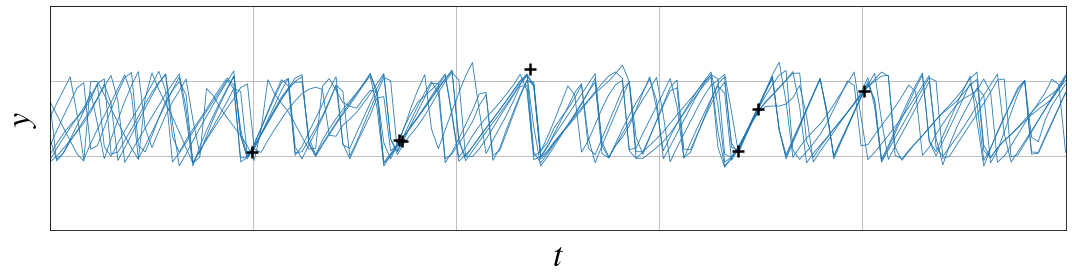

In [501]:
plt.figure(figsize=(15, 4))
plt.plot(x_samples, noiseless_samples.elements[0][:8, 0, 0, :].T, color="tab:blue", linewidth=0.8)
plt.scatter(
    batch["contexts"][0][0][0, 0, :],
    batch["contexts"][0][1][0, 0, :],
    marker="+",
    color="k",
    s=150,
    zorder=3,
    linewidth=2.5,
)
plt.xlim([-3., 3.])
plt.ylim([-0.5, 1.5])
plt.xticks(np.linspace(-3., 3., 6), []*7)
plt.yticks(np.linspace(-0.5, 1.5, 4), []*6)
plt.grid(zorder=1)
plt.tick_params(left=False, bottom=False)
plt.xlabel("$t$", fontsize=34)
plt.ylabel("$y$", fontsize=34)
plt.tight_layout()
counter = save_and_increment(path=path, counter=counter, show=show)

In [502]:
# from scipy.stats import gaussian_kde

# samples = noiseless_samples.elements[0][:, 0, 0, :].detach().numpy()
# smin = np.min(samples)
# smax = np.max(samples)
# smin, smax = smin - (smax - smin) / 10, smax + (smax - smin) / 10

# yplot = np.linspace(smin, smax, 200)

# for i in range(samples.shape[-1]):
    
#     kernel = gaussian_kde(samples[:, i])
    
#     print(i)
#     plt.plot(yplot, kernel(yplot))
#     plt.xlim([smin, smax])
#     plt.ylim([0, 5])
#     plt.show()

In [546]:
def make_gridplot(axes_off=False, figsize=(15, 5)):
    
    fig = plt.figure(constrained_layout=True, figsize=figsize)

    gs = GridSpec(5, 4, figure=fig)
    ax0 = fig.add_subplot(gs[:3, :])
    ax1 = fig.add_subplot(gs[3:, 0])
    ax2 = fig.add_subplot(gs[3:, 1])
    ax3 = fig.add_subplot(gs[3:, 2])
    ax4 = fig.add_subplot(gs[3:, 3])

    axs = [ax1, ax2, ax3, ax4]

    ax0.set_xlim([-3., 3.])
    ax0.set_ylim([-0.5, 1.5])
    ax0.set_xticks(np.linspace(-3., 3., 6), []*7)
    ax0.set_yticks(np.linspace(-0.5, 1.5, 4), []*6)
    ax0.grid(zorder=1)

    ax0.set_xlim([-3., 3.])
    ax0.set_ylim([-0.5, 1.5])
    ax0.set_xticks(np.linspace(-3., 3., 6), []*6)
    ax0.set_yticks(np.linspace(-0.5, 1.5, 4), []*4)
    ax0.tick_params(left=False, bottom=False)
    
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        
        if axes_off:
            ax.axis("off")
    
    return fig, ax0, axs


def make_gridplot_half(axes_off=False, figsize=(7.5, 5)):
    
    fig = plt.figure(constrained_layout=True, figsize=figsize)

    gs = GridSpec(6, 2, figure=fig)
    ax0 = fig.add_subplot(gs[:4, :])
    ax1 = fig.add_subplot(gs[4:, 0])
    ax2 = fig.add_subplot(gs[4:, 1])

    axs = [ax1, ax2]

    ax0.set_xlim([-3., 3.])
    ax0.set_ylim([-0.5, 1.5])
    ax0.set_xticks(np.linspace(-3., 3., 6), []*7)
    ax0.set_yticks(np.linspace(-0.5, 1.5, 4), []*6)
    ax0.grid(zorder=1)

    ax0.set_xlim([-3., 3.])
    ax0.set_ylim([-0.5, 1.5])
    ax0.set_xticks(np.linspace(-3., 3., 6), []*6)
    ax0.set_yticks(np.linspace(-0.5, 1.5, 4), []*4)
    ax0.tick_params(left=False, bottom=False)
    
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        
        if axes_off:
            ax.axis("off")
    
    return fig, ax0, axs

In [547]:
# np.random.seed(0)
# torch.random.manual_seed(0)
# state = B.create_random_state(torch.float32, seed=0)
# path = "img/sawtooth/sawtooth"
# show = True
# counter = 0
# stop_frames = 5

# x_plot = torch.linspace(-3., 3., 500)[None, None, :]

# N = batch["contexts"][0][0].shape[-1]
# N0 = 3

# contexts = [
#     (
#         batch["contexts"][0][0][:, :, :i],
#         batch["contexts"][0][1][:, :, :i]
#     )
# ]

# state, pred = model(state, contexts, x_plot)

# _x_plot = x_plot.detach().numpy()[0, 0, :]
# _mean = pred.mean.detach().numpy()[0, 0, :]
# _std = pred.var.detach().numpy()[0, 0, :]**0.5

# _xc = batch["contexts"][0][0][0, 0, :].detach().numpy()
# _yc = batch["contexts"][0][1][0, 0, :].detach().numpy()

In [548]:
# fig, ax0, axs = make_gridplot(axes_off=True)

# ax0.plot(_x_plot, _mean, color="tab:blue", alpha=1.0, zorder=2)
# ax0.scatter(_xc[:i], _yc[:i], marker="+", color="black", s=150, zorder=3, linewidth=2.5)
# ax0.scatter(_xc[i:N], _yc[i:N], marker="+", color="red", s=150, zorder=3, linewidth=2.5)
# ax0.fill_between(_x_plot, _mean-2.*_std, _mean+2.*_std, color="tab:blue", alpha=0.5, zorder=2)
# ax0.set_xlim([-3., 3.])
# ax0.set_ylim([-0.5, 1.5])
# ax0.set_xticks(np.linspace(-3., 3., 6), []*6)
# ax0.set_yticks(np.linspace(-0.5, 1.5, 4), []*4)
# ax0.grid(zorder=1)
# ax0.tick_params(left=False, bottom=False)
# plt.subplots_adjust(left=1e-2, right=1.-1e-2, bottom=1e-2, top=1.-1e-2, wspace=0.1, hspace=0.5)
# plt.savefig("img/sawtooth/sawtooth-first.pdf")

In [549]:
# counter = 0
# path = "img/sawtooth/sawtooth-conditioning"

# # First condition on the crosses
# for i in range(N0, N):
    
#     contexts = [
#         (
#             batch["contexts"][0][0][:, :, :i],
#             batch["contexts"][0][1][:, :, :i]
#         )
#     ]
    
#     state, pred = model(state, contexts, x_plot)
    
#     _x_plot = x_plot.detach().numpy()[0, 0, :]
#     _mean = pred.mean.detach().numpy()[0, 0, :]
#     _std = pred.var.detach().numpy()[0, 0, :]**0.5

#     _xc = batch["contexts"][0][0][0, 0, :].detach().numpy()
#     _yc = batch["contexts"][0][1][0, 0, :].detach().numpy()
    
#     fig, ax0, axs = make_gridplot(axes_off=True)
    
#     ax0.plot(_x_plot, _mean, color="tab:blue", alpha=1.0)
#     ax0.scatter(_xc[:i], _yc[:i], marker="+", color="k", s=150, zorder=3, linewidth=2.5)
#     ax0.plot([_xc[i:i+1], _xc[i:i+1]], [-0.5, 1.5], "--", color="k", zorder=2)
#     ax0.scatter(_xc[i:i+1], _yc[i:i+1], marker="+", color="green", s=150, zorder=3, linewidth=2.5)
#     ax0.scatter(_xc[i+1:N], _yc[i+1:N], marker="+", color="red", s=150, zorder=3, linewidth=2.5)
#     ax0.fill_between(_x_plot, _mean-2.*_std, _mean+2.*_std, color="tab:blue", alpha=0.5)
#     ax0.grid(zorder=1)
#     ax0.tick_params(left=False, bottom=False)
#     plt.subplots_adjust(left=1e-2, right=1.-1e-2, bottom=1e-2, top=1.-1e-2, wspace=0.1, hspace=0.5)
    
#     counter = save_and_increment(path=path, counter=counter, show=show)

In [550]:
# fig, ax0, axs = make_gridplot(axes_off=True)

# ax0.plot(_x_plot, _mean, color="tab:blue", alpha=1.0)
# ax0.scatter(_xc[:N], _yc[:N], marker="+", color="k", s=150, zorder=3, linewidth=2.5)
# ax0.fill_between(_x_plot, _mean-2.*_std, _mean+2.*_std, color="tab:blue", alpha=0.5)
# ax0.grid(zorder=1)
# ax0.tick_params(left=False, bottom=False)
# plt.subplots_adjust(left=1e-2, right=1.-1e-2, bottom=1e-2, top=1.-1e-2, wspace=0.1, hspace=0.5)
# plt.savefig("img/sawtooth/sawtooth-conditioned.pdf")
# plt.show()

In [551]:
# K = 15
# counter = 0
# path = "img/sawtooth/sawtooth-ar"
# x_sample = list(np.linspace(-2.8, 2.8, K) + 0.4 * np.random.uniform(size=(K,)) - 0.2)

# x_nexts = []
# y_nexts = []
    
# # Then sample and condition on grid points at random
# for i in range(K):
    
#     state, pred = model(state, contexts, x_plot)
    
#     _x_plot = x_plot.detach().numpy()[0, 0, :]
#     _mean = pred.mean.detach().numpy()[0, 0, :]
#     _std = pred.var.detach().numpy()[0, 0, :]**0.5

#     _xc = batch["contexts"][0][0][0, 0, :].detach().numpy()
#     _yc = batch["contexts"][0][1][0, 0, :].detach().numpy()
    
    
#     k = np.random.randint(len(x_sample))
#     x_next = torch.tensor([x_sample.pop(k)], dtype=torch.float32)[None, None, :]
    
#     state, pred = model(state, contexts, x_next)
    
#     y_next = pred.sample()
    
#     contexts = [
#         (
#             torch.concat([contexts[0][0], x_next], axis=-1),
#             torch.concat([contexts[0][1], y_next], axis=-1)
#         )
#     ]
    
#     fig, ax0, axs = make_gridplot(axes_off=True)
    
#     ax0.plot(_x_plot, _mean, color="tab:blue", alpha=1.0)
#     ax0.scatter(_xc[:N], _yc[:N], marker="+", color="k", s=150, zorder=3, linewidth=2.5)
#     ax0.scatter(x_next[0, 0, 0], y_next[0, 0, 0], marker="+", color="tab:green", s=150, zorder=3, linewidth=2.5)
#     ax0.scatter(x_nexts, y_nexts, marker="+", color="tab:purple", s=150, zorder=3, linewidth=2.5)
#     ax0.plot([x_next[0, 0, 0], x_next[0, 0, 0]], [-0.5, 1.5], "--", color="k")
#     ax0.fill_between(_x_plot, _mean-2.*_std, _mean+2.*_std, color="tab:blue", alpha=0.5)
#     ax0.grid(zorder=1)
#     ax0.tick_params(left=False, bottom=False)

#     x_nexts.append(x_next.detach().numpy())
#     y_nexts.append(y_next.detach().numpy())
    
#     plt.subplots_adjust(left=1e-2, right=1.-1e-2, bottom=1e-2, top=1.-1e-2, wspace=0.1, hspace=0.5)
#     counter = save_and_increment(path=path, counter=counter, show=show)

In [552]:
# fig, ax0, axs = make_gridplot(axes_off=True)

# ax0.plot(_x_plot, _mean, color="tab:blue", alpha=1.0)
# ax0.scatter(_xc[:N], _yc[:N], marker="+", color="k", s=150, zorder=3, linewidth=2.5)
# ax0.scatter(x_nexts, y_nexts, marker="+", color="tab:purple", s=150, zorder=3, linewidth=2.5)
# ax0.fill_between(_x_plot, _mean-2.*_std, _mean+2.*_std, color="tab:blue", alpha=0.5)
# plt.subplots_adjust(left=1e-2, right=1.-1e-2, bottom=1e-2, top=1.-1e-2, wspace=0.1, hspace=0.5)
# plt.savefig("img/sawtooth/sawtooth-sampled.pdf")

In [553]:
# fig, ax0, axs = make_gridplot(axes_off=True)
    
# ax0.plot(_x_plot, _mean, color="tab:blue", alpha=1.0)
# ax0.scatter(_xc[:N], _yc[:N], marker="+", color="k", s=150, zorder=3, linewidth=2.5)
# ax0.grid(zorder=1)
# ax0.tick_params(left=False, bottom=False)
# plt.subplots_adjust(left=1e-2, right=1.-1e-2, bottom=1e-2, top=1.-1e-2, wspace=0.1, hspace=0.5)
# plt.savefig("img/sawtooth/sawtooth-single-samples.pdf")

In [554]:
# fig, ax0, axs = make_gridplot(axes_o~ff=True)

# ax0.plot(x_samples, noiseless_samples.elements[0][:12, 0, 0, :].T, color="tab:blue", linewidth=0.8)
# ax0.scatter(
#     batch["contexts"][0][0][0, 0, :],
#     batch["contexts"][0][1][0, 0, :],
#     marker="+",
#     color="k",
#     s=150,
#     zorder=3,
#     linewidth=2.5
# )

# ax0.grid(zorder=1)
# ax0.tick_params(left=False, bottom=False)
# plt.subplots_adjust(left=1e-2, right=1.-1e-2, bottom=1e-2, top=1.-1e-2, wspace=0.1, hspace=0.5)
# plt.savefig("img/sawtooth/sawtooth-many-samples.pdf")

In [593]:
x_samples = torch.linspace(-3., 3., 150)

mean, variance, noiseless_samples, noisy_samples = nps.ar_predict(
    model,
    batch["contexts"],
    nps.AggregateInput((x_samples[None, None, :], 0)),
    num_samples=248,
)

mean = mean.elements[0][0, 0, :].detach().numpy()
std = variance.elements[0][0, 0, :].detach().numpy()**0.5

In [594]:
# xidx = [15, 50, 86, 130]
# smin = x_samples.min()
# smax = x_samples.max()
# yplot = np.linspace(smin, smax, 200)
# samples = noiseless_samples.elements[0][:, 0, 0, :]

# fig, ax0, axs = make_gridplot(figsize=(12, 3))

# ax0.plot(x_samples, noiseless_samples.elements[0][:6, 0, 0, :].T, color="tab:blue", linewidth=0.8)
# ax0.scatter(
#     batch["contexts"][0][0][0, 0, :],
#     batch["contexts"][0][1][0, 0, :],
#     marker="+",
#     color="k",
#     s=150,
#     zorder=3,
#     linewidth=2.5
# )

# for i, (ax, xidx) in enumerate(zip(axs, xidx)):

#     kernel = gaussian_kde(samples[:, xidx])
#     values = kernel(yplot)

#     vmin = 0
#     vmax = 1.1 * np.max(values)

#     ax.plot(yplot, values)
#     ax.set_xlim([smin, smax])
#     ax.set_ylim([vmin, vmax])

#     con = ConnectionPatch(
#         xyA=[smin, vmax],
#         xyB=[x_samples[xidx].detach().numpy(), -0.5],
#         coordsA="data",
#         coordsB="data",
#         axesA=ax,
#         axesB=ax0,
#     )
#     con.set_in_layout(False)
#     ax.add_artist(con)

#     con = ConnectionPatch(
#         xyA=[smax, vmax],
#         xyB=[x_samples[xidx].detach().numpy(), -0.5],
#         coordsA="data",
#         coordsB="data",
#         axesA=ax,
#         axesB=ax0,
#     )
#     con.set_in_layout(False)
#     ax.add_artist(con)

#     ax0.plot([x_samples[xidx], x_samples[xidx]], [-0.5, 1.5], "--", color="k")
#     ax.fill_between(yplot, np.zeros_like(yplot), values, alpha=0.2)

# plt.subplots_adjust(left=1e-2, right=1.-1e-2, bottom=1e-2, top=1.-1e-2, wspace=0.1, hspace=0.5)
# # plt.savefig("img/sawtooth/sawtooth-ar-samples.pdf")
# plt.show()

LinAlgError: singular matrix

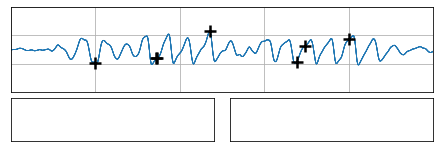

In [592]:
xidx = [91, 133]
smin = x_samples.min()
smax = x_samples.max()
yplot = np.linspace(smin, smax, 200)
samples = noiseless_samples.elements[0][:, 0, 0, :]

fig, ax0, axs = make_gridplot_half(figsize=(6, 2))

ax0.plot(x_samples, noiseless_samples.elements[0][:6, 0, 0, :].T, color="tab:blue", linewidth=0.8)
ax0.scatter(
    batch["contexts"][0][0][0, 0, :],
    batch["contexts"][0][1][0, 0, :],
    marker="+",
    color="k",
    s=150,
    zorder=3,
    linewidth=2.5
)

for i, (ax, xidx) in enumerate(zip(axs, xidx)):

    kernel = gaussian_kde(samples[:, xidx])
    values = kernel(yplot)

    vmin = 0
    vmax = 1.1 * np.max(values)

    ax.plot(yplot, values)
    ax.set_xlim([smin, smax])
    ax.set_ylim([vmin, vmax])

    con = ConnectionPatch(
        xyA=[smin, vmax],
        xyB=[x_samples[xidx].detach().numpy(), -0.5],
        coordsA="data",
        coordsB="data",
        axesA=ax,
        axesB=ax0,
    )
    con.set_in_layout(False)
    ax.add_artist(con)

    con = ConnectionPatch(
        xyA=[smax, vmax],
        xyB=[x_samples[xidx].detach().numpy(), -0.5],
        coordsA="data",
        coordsB="data",
        axesA=ax,
        axesB=ax0,
    )
    con.set_in_layout(False)
    ax.add_artist(con)

    ax0.plot([x_samples[xidx], x_samples[xidx]], [-0.5, 1.5], "--", color="k")
    ax0.set_xlim([0., 3.])
    ax.fill_between(yplot, np.zeros_like(yplot), values, alpha=0.2)

plt.subplots_adjust(left=1e-2, right=1.-1e-2, bottom=1e-2, top=1.-1e-2, wspace=0.1, hspace=0.5)
plt.savefig("img/sawtooth/sawtooth-ar-samples-half-resized.pdf")
plt.show()

In [589]:
x_samples = torch.linspace(-3., 3., 500)

mean, variance, noiseless_samples, noisy_samples = nps.predict(
    model,
    batch["contexts"],
    nps.AggregateInput((x_samples[None, None, :], 0)),
    num_samples=2048,
)

mean = mean.elements[0][0, 0, :].detach().numpy()
std = variance.elements[0][0, 0, :].detach().numpy()**0.5

In [590]:
# xidx = (np.array([15, 50, 86, 130]) / 150 * 500).astype(np.int32)
# smin = x_samples.min()
# smax = x_samples.max()
# yplot = np.linspace(smin, smax, 200)
# samples = noisy_samples.elements[0][:, 0, 0, :]

# fig, ax0, axs = make_gridplot(figsize=(12, 3))

# ax0.plot(x_samples, noisy_samples.elements[0][:12, 0, 0, :].T, color="tab:blue", linewidth=0.8)
# ax0.scatter(
#     batch["contexts"][0][0][0, 0, :],
#     batch["contexts"][0][1][0, 0, :],
#     marker="+",
#     color="k",
#     s=150,
#     zorder=3,
#     linewidth=2.5,
# )

# for i, (ax, xidx) in enumerate(zip(axs, xidx)):

# #     kernel = gaussian_kde(samples[:, xidx])
# #     values = kernel(yplot)
    
#     gaussian = norm(loc=mean[xidx], scale=variance.elements[0][0, 0, xidx]**0.5)
#     values = gaussian.pdf(yplot)

#     vmin = 0
#     vmax = 1.1 * np.max(values)

#     ax.plot(yplot, values)
#     ax.set_xlim([smin, smax])
#     ax.set_ylim([vmin, vmax])

#     con = ConnectionPatch(
#         xyA=[smin, vmax],
#         xyB=[x_samples[xidx].detach().numpy(), -0.5],
#         coordsA="data",
#         coordsB="data",
#         axesA=ax,
#         axesB=ax0,
#     )
#     con.set_in_layout(False)
#     ax.add_artist(con)

#     con = ConnectionPatch(
#         xyA=[smax, vmax],
#         xyB=[x_samples[xidx].detach().numpy(), -0.5],
#         coordsA="data",
#         coordsB="data",
#         axesA=ax,
#         axesB=ax0,
#     )
#     con.set_in_layout(False)
#     ax.add_artist(con)

#     ax0.plot([x_samples[xidx], x_samples[xidx]], [-0.5, 1.5], "--", color="k")
#     ax.fill_between(yplot, np.zeros_like(yplot), values, alpha=0.2)

# plt.subplots_adjust(left=1e-2, right=1.-1e-2, bottom=1e-2, top=1.-1e-2, wspace=0.1, hspace=0.5)
# plt.savefig("img/sawtooth/sawtooth-noisy-samples.pdf")
# plt.show()

/Users/stratis/repos/qif/venv-qif/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


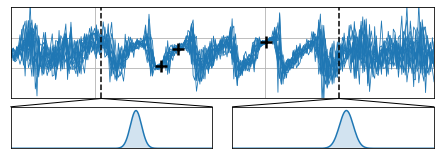

In [591]:
xidx = (np.array([91, 133]) / 150 * 500).astype(np.int32)
smin = x_samples.min()
smax = x_samples.max()
yplot = np.linspace(smin, smax, 200)
samples = noisy_samples.elements[0][:, 0, 0, :]

fig, ax0, axs = make_gridplot_half(figsize=(6, 2))

ax0.plot(x_samples, noisy_samples.elements[0][:12, 0, 0, :].T, color="tab:blue", linewidth=0.8)
ax0.scatter(
    batch["contexts"][0][0][0, 0, :],
    batch["contexts"][0][1][0, 0, :],
    marker="+",
    color="k",
    s=150,
    zorder=3,
    linewidth=2.5,
)

for i, (ax, xidx) in enumerate(zip(axs, xidx)):

#     kernel = gaussian_kde(samples[:, xidx])
#     values = kernel(yplot)
    
    gaussian = norm(loc=mean[xidx], scale=variance.elements[0][0, 0, xidx]**0.5)
    values = gaussian.pdf(yplot)

    vmin = 0
    vmax = 1.1 * np.max(values)

    ax.plot(yplot, values)
    ax.set_xlim([smin, smax])
    ax.set_ylim([vmin, vmax])

    con = ConnectionPatch(
        xyA=[smin, vmax],
        xyB=[x_samples[xidx].detach().numpy(), -0.5],
        coordsA="data",
        coordsB="data",
        axesA=ax,
        axesB=ax0,
    )
    con.set_in_layout(False)
    ax.add_artist(con)

    con = ConnectionPatch(
        xyA=[smax, vmax],
        xyB=[x_samples[xidx].detach().numpy(), -0.5],
        coordsA="data",
        coordsB="data",
        axesA=ax,
        axesB=ax0,
    )
    con.set_in_layout(False)
    ax.add_artist(con)

    ax0.plot([x_samples[xidx], x_samples[xidx]], [-0.5, 1.5], "--", color="k")
    ax0.set_xlim([0., 3.])
    ax.fill_between(yplot, np.zeros_like(yplot), values, alpha=0.2)

plt.subplots_adjust(left=1e-2, right=1.-1e-2, bottom=1e-2, top=1.-1e-2, wspace=0.1, hspace=0.5)
plt.savefig("img/sawtooth/sawtooth-noisy-samples-half.pdf")
plt.show()